# Depolarizing channel

This notebook reproduces the results of Fig. 4 in the paper, using the circuit described in Fig. 9.

The notebook is divided in different sections:

1. [Circuit preparation](#circuit_preparation) where the circuits are prepared 
2. [Simulation](#simulation) where they are simulated locally
3. [Execution on the real device](#execution) where the jobs are sent for execution on the IBM Q devices
4. [Analysis of the result](#analysis) where the results are collected and the plot is made

This notebook was tested with qiskit 0.12.1 and Python 3.7.4

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import json
import copy

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Tomography
from qiskit.ignis.verification.tomography import state_tomography_circuits
from qiskit.ignis.verification.tomography import StateTomographyFitter

# Calibration
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, 
                                                CompleteMeasFitter, 
                                                MeasurementFilter)

# Utility functions
from qiskit.tools.qi.qi import partial_trace
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.jobstatus import JobStatus

In [2]:
# Shows a window in the upper left part with real-time information 
# on the status of the jobs running on the IBM Q device
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [3]:
# We use ibmqx2, but ibmq_vigo and ibmq_ourense work as well
IBMQ.load_account()
backend = IBMQ.get_provider().get_backend('ibmqx2')

# Local simulator and vector simulator
simulator = Aer.get_backend('qasm_simulator')
vector_backend = Aer.get_backend('statevector_simulator')

### 1. Circuit preparation <a id='circuit_preparation'></a>

In [6]:
from depolarizing_channel import depolarizing_channel_3q as depolarizing_channel

SHOTS = 8192

# The values for p
p_values = np.linspace(0, 1, 15)

# We create the quantum circuit
q = QuantumRegister(5, name='q')
c = ClassicalRegister(1, name='c')

# Index of the system qubit
system = 2

# Indices of the ancillary qubits
ancillae = [1, 3, 4]

# Prepare the qubit in a state that has coherence and different populations 
prepare_state = QuantumCircuit(q)
prepare_state.u3(np.pi/4, np.pi/4, 0, q[system])   

# We append the measurements for the tomography
tomo_circuits = []
for p in p_values:
    circ = prepare_state + depolarizing_channel(q, p, system, ancillae)
    tomo_circuits += state_tomography_circuits(circ, q[system])

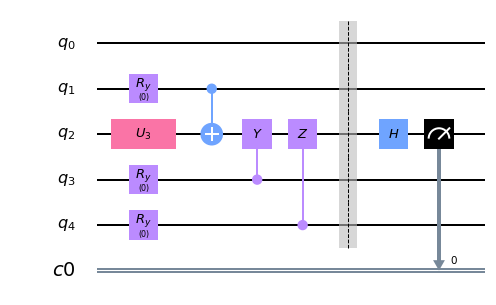

In [7]:
tomo_circuits[0].draw(output='mpl')

Drawing of one of the circuists, with measurement on the `x` basis.

### 2. Simulation <a id="simulation"/>

This cell executes locally the (noiseless) simulation of the circuits above.

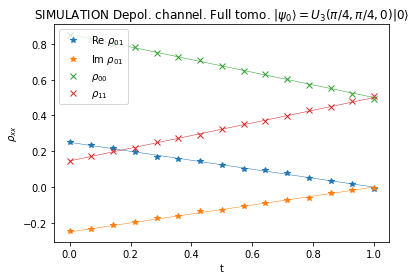

In [9]:
job = execute(tomo_circuits, backend=simulator, shots = SHOTS)

rhos = np.zeros((2,2,len(p_values)), dtype=complex)

for (i, p) in enumerate(p_values):
    test_result = copy.deepcopy(job.result())
    test_result.results = test_result.results[3*i:3*i+3]
    tomo_fitter = StateTomographyFitter(test_result, tomo_circuits[3*i:3*i+3])
    rhos[:,:,i] = tomo_fitter.fit()

# Simulated results
plt.plot(p_values, np.real(rhos[0,1,:]),"C0*", label='Re $\\rho_{01}$')
plt.plot(p_values, np.imag(rhos[0,1,:]),"C1*", label='Im $\\rho_{01}$')
plt.plot(p_values, np.real(rhos[0,0,:]),"C2x", label='$\\rho_{00}$')
plt.plot(p_values, np.real(rhos[1,1,:]),"C3x", label='$\\rho_{11}$')

# Theoretical prediction
rho0 = partial_trace(execute(prepare_state, vector_backend).result().get_statevector(), [0,1,3,4])

plt.plot(p_values, np.real(rho0[0,1])*(1-p_values), "C0", linewidth=.5)
plt.plot(p_values, np.imag(rho0[0,1])*(1-p_values), "C1", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[0,0])*(1-p_values), "C2", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[1,1])*(1-p_values), "C3", linewidth=.5)

plt.xlabel('t')
plt.ylabel('$\\rho_{xx}$')
plt.legend();

plt.title("SIMULATION Depol. channel. Full tomo. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$");

### 3. Execution on the real device <a id="execution" />

In [10]:
# Run the calibration job
cal_circuits, state_labels = complete_meas_cal([system], q, c)
calibration_job = execute(cal_circuits, backend, shots=SHOTS)

job = execute(tomo_circuits, backend, shots=SHOTS)

experiment_data = [{
    "backend": backend.name(),
    "calibration": calibration_job.job_id(),
    "description": "Circuits for tomographic reconstruction of the depolarizing channel",
    "jobs": [{'jobid': job.job_id(),
              'description': '3 tomography circuits for each value of p',
              'metadata': {'p_values': list(p_values)}
             }]
    }]

filename = 'depolarizing_channel_{}.json'.format(
            datetime.now().strftime(("%Y_%m_%d-%H_%M")))

with open(filename,'w') as file:
    json.dump(experiment_data, file)

All the information about the experiment is stored in a JSON file called `depolarizing_channel_DATETIME.json`.

### 4. Analysis of the results <a id="analysis"/>
#### Instructions:
Use the `filename` variable to load the JSON file containing the experiment information

In [17]:
# List the available experiment files

import glob

print("Available experiment files:")
for f in glob.glob('*.json'):
    print(f)

Available experiment files:
depolarizing_channel_2019_10_11-10_47.json
depolarizing_channel_2019_10_11-11_11.json
depolarizing_channel_2019_10_11-11_24.json
depolarizing_channel_2019_10_11-12_49.json


In [18]:
filename = "depolarizing_channel_2019_10_11-12_49.json"

with open(filename, 'r') as file:
    experiment_data = json.load(file)

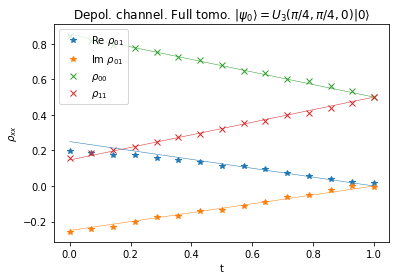

In [42]:
# Get the backend
backend = IBMQ.get_provider().get_backend(experiment_data[0]['backend'])

# Use the calibration job to implement the error mitigation
calibration_job = backend.retrieve_job(experiment_data[0]['calibration'])
meas_fitter = CompleteMeasFitter(calibration_job.result(), state_labels)
meas_filter = meas_fitter.filter

p_values = np.array(experiment_data[0]['jobs'][0]['metadata']['p_values'])

job = backend.retrieve_job(experiment_data[0]['jobs'][0]['jobid'])

# Apply the mitigation
result = job.result()
result = meas_filter.apply(result)

rhos = np.zeros((2,2,len(p_values)), dtype=complex)

# Reconstruct the density matrix for each of the values of p
for (i, p) in enumerate(p_values):
    # This is a bit of a hack to split the whole result into
    # smaller result objects containing the three tomography circuits
    # for a specific value of p
    test_result = copy.copy(result)
    test_result.results = test_result.results[3*i:3*i+3]
    tomo_fitter = StateTomographyFitter(test_result, tomo_circuits[3*i:3*i+3])
    rhos[:,:,i] = tomo_fitter.fit()

# Plot of the experimental points
plt.plot(p_values, np.real(rhos[0,1,:]), "C0*", label='Re $\\rho_{01}$')
plt.plot(p_values, np.imag(rhos[0,1,:]), "C1*", label='Im $\\rho_{01}$')
plt.plot(p_values, np.real(rhos[0,0,:]), "C2x", label='$\\rho_{00}$')
plt.plot(p_values, np.real(rhos[1,1,:]), "C3x", label='$\\rho_{11}$')

# Theoretical prediction
vector_backend = Aer.get_backend('statevector_simulator')
rho0 = partial_trace(execute(prepare_state, vector_backend).result().get_statevector(), [0,1,3,4])

plt.plot(p_values, np.real(rho0[0,1])*(1-p_values), "C0", linewidth=.5)
plt.plot(p_values, np.imag(rho0[0,1])*(1-p_values), "C1", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[0,0])*(1-p_values), "C2", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[1,1])*(1-p_values), "C3", linewidth=.5)

plt.xlabel('t')
plt.ylabel('$\\rho_{xx}$')
plt.legend();

plt.title("Depol. channel. Full tomo. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$");

The job contains info on the gate and measurement error rates

In [93]:
job.properties().qubits

[[Nduv(date=datetime.datetime(2019, 10, 10, 8, 48, 19, tzinfo=tzutc()), name='T1', unit='µs', value=74.85208690842674),
  Nduv(date=datetime.datetime(2019, 10, 10, 8, 49, 59, tzinfo=tzutc()), name='T2', unit='µs', value=63.00239136127134),
  Nduv(date=datetime.datetime(2019, 10, 10, 9, 50, 37, tzinfo=tzutc()), name='frequency', unit='GHz', value=5.286310100364124),
  Nduv(date=datetime.datetime(2019, 10, 10, 8, 46, 51, tzinfo=tzutc()), name='readout_error', unit='', value=0.011500000000000066),
  Nduv(date=datetime.datetime(2019, 10, 10, 8, 46, 51, tzinfo=tzutc()), name='prob_meas0_prep1', unit='', value=0.015000000000000013),
  Nduv(date=datetime.datetime(2019, 10, 10, 8, 46, 51, tzinfo=tzutc()), name='prob_meas1_prep0', unit='', value=0.008)],
 [Nduv(date=datetime.datetime(2019, 10, 10, 8, 48, 19, tzinfo=tzutc()), name='T1', unit='µs', value=55.91509286343368),
  Nduv(date=datetime.datetime(2019, 10, 10, 8, 51, 50, tzinfo=tzutc()), name='T2', unit='µs', value=49.94183738916608),
  Nd

In [94]:
job.properties().gates

[Gate(gate='id', name='id_0', parameters=[Nduv(date=datetime.datetime(2019, 10, 10, 8, 55, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.000530003638190013), Nduv(date=datetime.datetime(2019, 10, 10, 9, 50, 37, tzinfo=tzutc()), name='gate_length', unit='ns', value=35.55555555555556)], qubits=[0]),
 Gate(gate='u1', name='u1_0', parameters=[Nduv(date=datetime.datetime(2019, 10, 10, 8, 55, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.0), Nduv(date=datetime.datetime(2019, 10, 10, 9, 50, 37, tzinfo=tzutc()), name='gate_length', unit='ns', value=0.0)], qubits=[0]),
 Gate(gate='u2', name='u2_0', parameters=[Nduv(date=datetime.datetime(2019, 10, 10, 8, 55, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.000530003638190013), Nduv(date=datetime.datetime(2019, 10, 10, 9, 50, 37, tzinfo=tzutc()), name='gate_length', unit='ns', value=35.55555555555556)], qubits=[0]),
 Gate(gate='u3', name='u3_0', parameters=[Nduv(date=datetime.datetime(2019, 10, 10, 8, 55, 41, tzinfo